In [1]:
try:
    import jax
except:
    %pip install jax jaxlib
    import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

try:
    import matplotlib.pyplot as plt
except:
    %pip install matplotlib
    import matplotlib.pyplot as plt

try:
    import seaborn as sns
except:
    %pip install seaborn
    import seaborn as sns

try:
    import tinygp
except ModuleNotFoundError:
    %pip install -qqq tinygp
    import tinygp
kernels = tinygp.kernels
from tinygp import GaussianProcess

In [2]:
import os

LATEXIFY = "LATEXIFY" in os.environ

if LATEXIFY:
    import sys

    sys.path.append("scripts")
    from plot_utils import latexify, savefig

    latexify(width_scale_factor=2, fig_height=1.5)

## Samples from prior (noiseless & noisy)

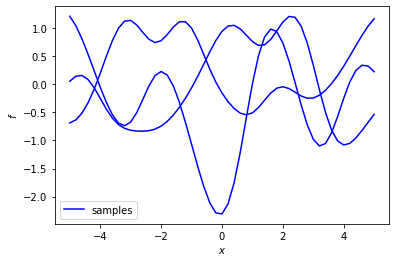

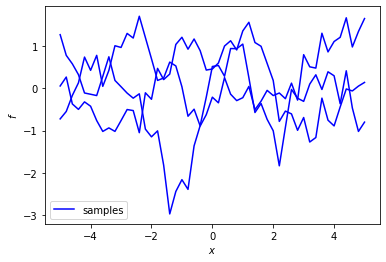

In [3]:
def sample_from_prior(key, data, save_name):
    kernel = kernels.ExpSquared(scale=1.0)
    gp = GaussianProcess(kernel, data["x"], diag=1e-8 + data["noise"])
    samples = gp.sample(key, shape=(data["n_samples"],))

    plt.figure()
    plt.plot(x, samples.T, color="b")
    plt.xlabel("$x$")
    plt.ylabel("$f$")
    plt.legend(["samples"], loc="lower left")
    if LATEXIFY:
        savefig(save_name)


key = jax.random.PRNGKey(0)
x = jnp.arange(-5, 5.2, 0.2)

data = {"noise": 0.0, "n_samples": 3, "x": x}
sample_from_prior(key, data, "gprDemoNoiseFreePrior_latexified.pdf")

data = {"noise": 1e-1, "n_samples": 3, "x": x}
sample_from_prior(key, data, "gprDemoNoisyPrior_latexified.pdf");

## Samples from posterior (noiseless & noisy)

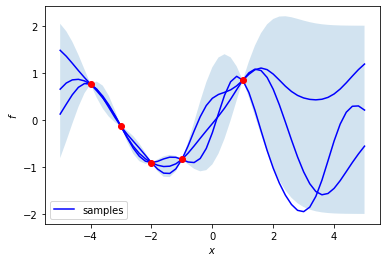

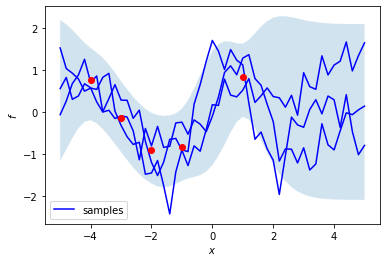

In [4]:
def sample_from_posterior(key, data, save_name):
    kernel = kernels.ExpSquared(scale=1.0)
    gp = GaussianProcess(kernel, data["x_train"], diag=1e-8 + data["noise"])
    pred_gp = gp.condition(data["y_train"], data["x_test"], diag=1e-8 + data["noise"]).gp
    samples = pred_gp.sample(key, shape=(data["n_samples"],))
    mean = pred_gp.mean
    std = pred_gp.variance**0.5

    plt.figure()
    plt.plot(data["x_test"], samples.T, color="b")
    plt.scatter(data["x_train"], data["y_train"], color="r", zorder=10)
    plt.fill_between(data["x_test"].flatten(), mean - 2 * std, mean + 2 * std, alpha=0.2)
    plt.xlabel("$x$")
    plt.ylabel("$f$")
    plt.legend(["samples"], loc="lower left")
    if LATEXIFY:
        savefig(save_name)


key = jax.random.PRNGKey(0)
x_train = jnp.array([[-4], [-3], [-2], [-1], [1]])
y_train = jnp.sin(x_train).flatten()

x_test = jnp.arange(-5, 5.2, 0.2)

data = {"noise": 0.0, "n_samples": 3, "x_train": x_train, "y_train": y_train, "x_test": x_test}
sample_from_posterior(key, data, "gprDemoNoiseFreePost_latexified.pdf")

data = {"noise": 0.1, "n_samples": 3, "x_train": x_train, "y_train": y_train, "x_test": x_test}
sample_from_posterior(key, data, "gprDemoNoisyPost_latexified.pdf")

## Demo (variable noise)

In [5]:
from ipywidgets import interact


@interact(random_state=(1, 10), noise=(0.0, 0.2, 0.01))
def animate_gp_regression(random_state=0, noise=0):
    key = jax.random.PRNGKey(random_state)
    data = {"noise": noise, "n_samples": 3, "x_train": x_train, "y_train": y_train, "x_test": x_test}
    sample_from_posterior(key, data, "")
    plt.title(f"noise: {noise}, random_state: {random_state}")

interactive(children=(IntSlider(value=1, description='random_state', max=10, min=1), FloatSlider(value=0.0, de…